In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.utils.prune as prune

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


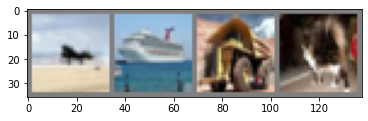

plane  ship truck   cat


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.conv3 = nn.Conv2d(16, 120, 5, bias=False)
        self.fc1 = nn.Linear(120, 84, bias=False)
        self.fc2 = nn.Linear(84, 10, bias=False)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 120)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    def prune_weights(self, amount):
            parameters_to_prune = (
                (self.conv1, 'weight'),
                (self.conv2, 'weight'),
                (self.conv3, 'weight'),
                (self.fc1, 'weight'),
                (self.fc2, 'weight'),
            )

            prune.global_unstructured(
                parameters_to_prune,
                pruning_method=prune.L1Unstructured,
                amount=amount,
            )

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (fc1): Linear(in_features=120, out_features=84, bias=False)
  (fc2): Linear(in_features=84, out_features=10, bias=False)
)

In [31]:
def n_params(model):
    print("Layer conv1 : ", torch.sum(model.conv1.weight_mask).item(), " / ", torch.sum(1*model.conv1.weight_mask >= 0).item())
    print("Layer conv2 : ", torch.sum(model.conv2.weight_mask).item(), " / ", torch.sum(1*model.conv2.weight_mask >= 0).item())
    print("Layer conv3 : ", torch.sum(model.conv3.weight_mask).item(), " / ", torch.sum(1*model.conv3.weight_mask >= 0).item())
    print("Layer fc1 : ", torch.sum(model.fc1.weight_mask).item(), " / ", torch.sum(1*model.fc1.weight_mask >= 0).item())
    print("Layer fc2 : ", torch.sum(model.fc2.weight_mask).item(), " / ", torch.sum(1*model.fc2.weight_mask >= 0).item())

In [32]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)

In [33]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            if i > 25:
                break
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times
    print("epoch " + str(epoch))
    if epoch > 0:
        net.prune_weights(0.2)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            test()

print('Finished Training')

epoch 0
Accuracy of the network on the 10000 test images: 61 %
Accuracy of the network on the 10000 test images: 57 %
Accuracy of the network on the 10000 test images: 62 %
Accuracy of the network on the 10000 test images: 65 %
Accuracy of the network on the 10000 test images: 65 %
Accuracy of the network on the 10000 test images: 62 %
epoch 1


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000178B8917CA0>
Traceback (most recent call last):
  File "C:\Users\timot\miniconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "C:\Users\timot\miniconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1174, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000178B8917CA0>
Traceback (most recent call last):
  File "C:\Users\timot\miniconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "C:\Users\timot\miniconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1174, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
Attribute

Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 59 %
Accuracy of the network on the 10000 test images: 60 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 62 %
Accuracy of the network on the 10000 test images: 59 %
epoch 2
Accuracy of the network on the 10000 test images: 64 %
Accuracy of the network on the 10000 test images: 64 %
Accuracy of the network on the 10000 test images: 62 %
Accuracy of the network on the 10000 test images: 61 %
Accuracy of the network on the 10000 test images: 59 %
Accuracy of the network on the 10000 test images: 65 %
epoch 3
Accuracy of the network on the 10000 test images: 57 %
Accuracy of the network on the 10000 test images: 60 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 59 %
Accuracy of the network on the 10000 test images:

In [39]:
n_params(net)

Layer conv1 :  240.0  /  450
Layer conv2 :  820.0  /  2400
Layer conv3 :  2150.0  /  48000
Layer fc1 :  701.0  /  10080
Layer fc2 :  334.0  /  840
